## Functions

**plot_dataset(X, y):**
- Plots a scatter plot of the dataset.
- Each point is colored according to its label `y`.
- Useful for visualizing the distribution and classes of the data.

**plot_hyperplane(vector, intercept=0, dataset=None):**
- Plots a straight line (hyperplane) defined by the weight vector and intercept.
- The line is shown in red.
- Used to visualize decision boundaries in 2D.

**sign(a):**
- Returns +1 if `a` is greater than or equal to 0, otherwise returns -1.
- Used to convert continuous values into binary class labels (+1 or -1).

**create_dataset(n=40, func=lambda a, b: bool(a) != bool(b)):**
- Generates a synthetic 2D dataset using `make_blobs` from scikit-learn.
- The labels are assigned using a custom function (default: XOR logic on the two coordinates).
- Returns the features `X` and the labels `y`.

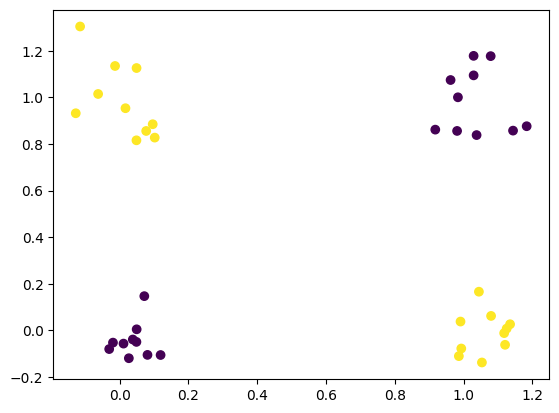

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs

def plot_dataset(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y)


def plot_hyperplane(vector, intercept=0, dataset=None):
    xs = np.array([0, 1])
    ys = -(vector[0] * xs + intercept) / vector[1]
    plt.plot(xs, ys, 'r-')

def sign(a):
    return (a >= 0) * 2 - 1


def create_dataset(n=40, func=lambda a, b: bool(a) != bool(b)):
    X, y = make_blobs(n_samples=n, centers=[[0, 0], [1, 0], [1, 1], [0, 1]], cluster_std=0.1)
    y = np.array([func(a > 0.5, b > 0.5) for a, b in zip(X[:, 0], X[:, 1])], dtype=int) * 2 - 1
    return X, y

X, y = create_dataset()

plot_dataset(X, y)
plt.show()

## Functions

**include_bias(X):**
- Adds a column of ones to the input matrix `X`.
- This allows models to learn a bias (intercept) term as part of the weights.

**tanh(a):**
- Converts the output of the sigmoid function to the range of the hyperbolic tangent (tanh), i.e., from [0, 1] to [-1, 1].
- Useful for activation functions in neural networks.

**get_axes_limits(X):**
- Calculates axis limits for plotting based on the minimum and maximum values in each feature of `X`.
- Adds a small offset for better visualization.
- Returns the limits as `[min_x, max_x, min_y, max_y]`.

**plot_predictions(clf, X):**
- Visualizes the decision regions of a classifier `clf` over the feature space of `X`.
- Creates a grid of points, predicts their labels, and plots the regions using filled contours.
- Helps to see how the model separates different classes in 2D.

In [2]:
from scipy.special import expit

include_bias = lambda X: np.c_[np.ones(X.shape[0]), X]  # Add bias column to input matrix

def tanh(a):
    return expit(a) * 2 - 1  # Convert sigmoid output to tanh range

def get_axes_limits(X):
    offset = 0.5
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1 - offset, max1 + offset, min2 - offset, max2 + offset]

def plot_predictions(clf, X):
    axes = get_axes_limits(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X_grid = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X_grid).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

### SingleHiddenLayer Neural Network with Backpropagation

This code defines a simple neural network with a single hidden layer for binary classification. Here’s a breakdown of each part:

- **Class Definition**:  
  `SingleHiddenLayer` inherits from `BaseEstimator` and `ClassifierMixin` for compatibility with scikit-learn utilities.

- **__init__**:  
  Initializes the model with the number of training iterations (`max_iter`) and the learning rate (`learning_rate`).

- **foward**:  
  - Adds a bias column to the input `X`.
  - Computes the hidden layer pre-activations (`pH`) using the input-to-hidden weights (`input_hidden_weights`).
  - Applies a sigmoid-to-tanh activation to get hidden layer outputs (`H`).
  - Adds a bias to the hidden layer output.
  - Computes the final predictions (`ypred`) using the hidden-to-output weights (`hidden_output_weights`).

- **backward**:  
  - Calculates the error between true labels `y` and predictions `ypred`.
  - Updates the output weights (`hidden_output_weights`) using the error and learning rate.
  - Stores the sum of squared errors as `cost_`.

- **fit**:  
  - Prepares the input and output data, adding bias and reshaping as needed.
  - Initializes the weights for both layers.
  - Runs the training loop for `max_iter` iterations, performing forward and backward passes to update weights.

- **predict**:  
  - Runs a forward pass on new data and returns the predicted class labels (+1 or -1).

- **Usage**:  
  - The model is instantiated and trained on data (`model.fit(X, y)`).
  - The accuracy is printed, and the decision regions and dataset are plotted for visualization.

**Note:**
- `hidden_output_weights` is a matrix of weights connecting the hidden layer (with bias) to the output layer. It is updated during training to minimize prediction error.

This implementation demonstrates the core ideas of a neural network: forward propagation, backpropagation, and weight updates using gradient descent.

Below is a diagram of a single hidden layer neural network with bias:
<img src="images/single_hidden_layer_with_bias.png" alt="Single Hidden Layer Neural Network with Bias" width="460"/>

1.0


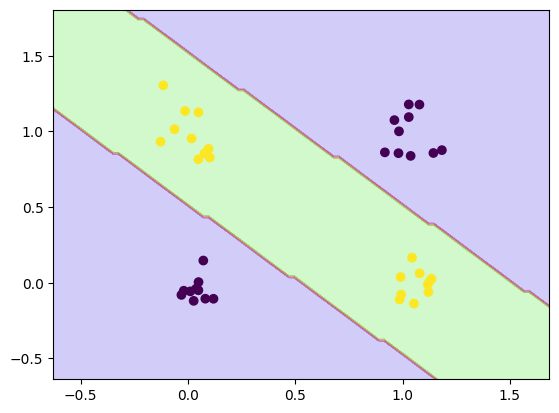

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

class SingleHiddenLayer(BaseEstimator, ClassifierMixin):
  def __init__(self, max_iter=1000, learning_rate=0.01):
    self.max_iter = max_iter
    self.learning_rate = learning_rate

  def forward(self, X):
    X_with_bias = include_bias(X)  # Add bias to input
    hidden_pre_activation = X_with_bias @ self.input_hidden_weights  # Compute hidden layer pre-activation
    self.hidden_output = tanh(hidden_pre_activation)  # Apply activation function (tanh-like)
    self.hidden_with_bias = include_bias(self.hidden_output)  # Add bias to hidden layer output
    predictions = self.hidden_with_bias @ self.hidden_output_weights  # Compute output layer predictions
    return predictions

  def backward(self, X_with_bias, y_true, y_pred):
    # --- Backpropagation ---
    output_error = y_true - y_pred  # 1. Compute error at output layer
    output_gradient = self.hidden_with_bias.T @ output_error  # 2. Compute gradient for output weights
    #### key insight #####
    hidden_activation_gradient = (1 - np.square(self.hidden_output))  # Derivative of tanh # 3a. Activation derivative
    hidden_error = (output_error @ self.hidden_output_weights[1:, :].T) * hidden_activation_gradient  # Propagate error back through output weights (excluding bias row) # 3b. Error signal for hidden layer
    #### #####
    hidden_gradient = X_with_bias.T @ hidden_error  # 4. Compute gradient for input-to-hidden weights
    self.hidden_output_weights += output_gradient * self.learning_rate  # 5a. Update output weights
    self.input_hidden_weights += hidden_gradient * self.learning_rate  # 5b. Update input-to-hidden weights
    self.cost_ = np.sum((output_error) ** 2)  # 6. Store cost (sum of squared errors)

  def fit(self, X, y):
    X_with_bias = include_bias(X)  # Add bias column to input data
    if len(y.shape) == 1:          # If y is a 1D array (shape: [n_samples,])
        y = y.reshape(-1, 1)       # Reshape y to a column vector (shape: [n_samples, 1])
    self.input_hidden_weights = np.random.uniform(-1, 1, size=(X_with_bias.shape[1], 2))  # Initialize input-to-hidden weights randomly
    self.hidden_output_weights = np.random.uniform(-1, 1, size=(self.input_hidden_weights.shape[1] + 1, y.shape[1]))  # Initialize hidden-to-output weights randomly (add 1 for bias)
    for _ in range(self.max_iter):  # Loop for the specified number of training iterations
        y_pred = self.forward(X)    # Compute predictions (forward pass)
        self.backward(X_with_bias, y, y_pred)  # Update weights using backpropagation
    return self                    # Return the trained model instance

  def predict(self, X):
    y_pred = self.forward(X)
    return sign(y_pred)

model = SingleHiddenLayer()  # Instantiate and train the model
model.fit(X, y)
print(accuracy_score(y, model.predict(X)))  # Print accuracy and plot results
plot_predictions(model, X)
plot_dataset(X, y)
plt.show()